# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI method and create high-quality plots of the results.

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

This tutorial explains the missing values and masking and gives walk-through examples. See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [8]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction


## Missing values and masking

### Missing values

Tigramite consistently handles missing values. For example, missing values denoted as ``999.`` in the data can be flagged with ``ParCorr.set_dataframe(data, missing_flag=999.)``. Then all time slices of samples where missing values occur in any variable are dismissed while consistently handling time lags. To avoid biases also subsequent samples for all lags up to ``2*tau_max`` are dismissed. Missing values and masking will be described in more detail in a future paper.


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic

##
## Running Tigramite PC algorithm
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = 0.2
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Iterating through pc_alpha = [0.2]:

# pc_alpha = 0.2 (1/1):

Testing condition sets of dimension 0:

    Link ($X^0$ -1) --> $X^0$ (1/6):
            Constructed array of shape (2, 58) from
            X = [(0, -1)]
            Y = [(0, 0)]
            Z = []
            with missing values = 999.0 removed
    Combination 0:  --> pval = 0.00000 / val = 0.682
    No conditions of dimension 0 left.

    Link ($X^0$ -2) --> $X^0$ (2/6):
            Constructed array of shape (2, 58) from
            X = [(0, -2)]
            Y = [(0, 0)]
            Z = []
            with missing values = 999.0 removed
    Combination 0:  --> pval = 0.00002 / val = 0.532
    No conditions of dimension 0 left.

  

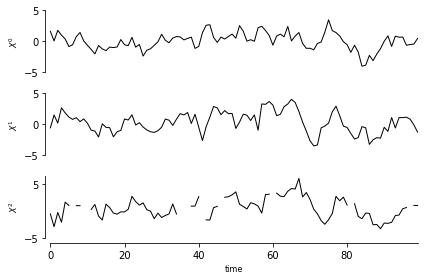

In [2]:
np.random.seed(1)
data = np.random.randn(100, 3)
for t in range(1, 100):
    data[t, 0] += 0.7*data[t-1, 0] 
    data[t, 1] += 0.6*data[t-1, 1] + 0.6*data[t-1,0]
    data[t, 2] += 0.5*data[t-1, 2] + 0.6*data[t-1,1]
# Randomly mark 10% of values as missing values in variable 2
data[np.random.permutation(100)[:10], 2] = 999.

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names,
                         missing_flag=999.)

tp.plot_timeseries(dataframe)
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(verbosity=3), verbosity=4)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

### Masking

Different from missing values, masking can be used to include or exclude samples depending on the situation: For example, in climate research we frequently are interested to detect the drivers of a target variable *only in winter months*. Suppose we are given dataseries ($X^1, X^2, X^3$) and want to estimate the causal parents affecting the variables in winter months. This can be achieved with ``mask_type='y'`` in initializing ``ParCorr`` and marking all winter month data in ($X^1, X^2, X^3$) in ``mask`` with a ``1`` (or ``True``). During a PCMCI analysis many independent tests $X_{t-\tau} \perp Y_t | Z$ are carried out, where $X,Y,Z$ denote any of the $X^1,X^2,X^3$ in different iterations of the PCMCI analysis. For example, to estimate the parents of $X^2$, the argument $X_{t-\tau}$ as well as $Z$ will iterate through ($X^1, X^2, X^3$) including their lags.  Then Tigramite considers samples of $Y=X^2$ from the winter only using the mask of $X^2$, while lagged samples of $X$ or $Z$ can also come, e.g., from the previous summer. If we want *all* samples, also in $X$ and $Z$ to be restricted to the respective mask, we need to mark them in ``mask`` as well and set  ``mask_type='yxz'``. Correspondingly, also  ``mask_type='z'`` or any combination is possible. Missing values and masking will be described in more detail in a future paper.

In the following example, we generate data with a different underlying causality for winter and summer months. In particular, assume a causal effect is of opposite sign in both seasons.

(<Figure size 576x216 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd3db89208>,
       dtype=object))

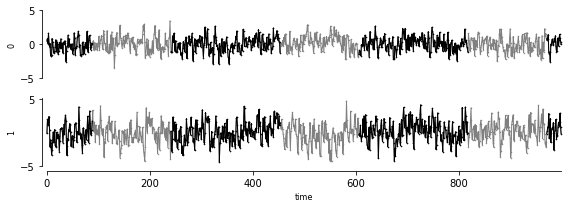

In [4]:
# Masking demo: We consider time series where the one part is generated by a different
# causal process than the other part. 
np.random.seed(42)
T = 1000
data = np.random.randn(T, 2)
data_mask = np.zeros(data.shape)
for t in range(1, T):
#     print t % 365
    if (t % 365) < 3*30 or (t % 365) > 8*30: 
        # Winter half year
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] + 0.9*data[t-1, 0]
    else:
        # Summer half year
        data_mask[[t, t-1]] = True
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] - 0.9*data[t-1, 0]

T, N = data.shape
# print data_mask[:100, 0]
dataframe = pp.DataFrame(data, mask=data_mask)
tp.plot_timeseries(dataframe, figsize=(8,3), use_mask=True, grey_masked_samples='data')


In [5]:
# Setup analysis
def run_and_plot(cond_ind_test, fig_ax):
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmci(tau_max=2,pc_alpha=0.2, )
    link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
    tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
                  link_matrix=link_matrix, var_names=var_names,
    )

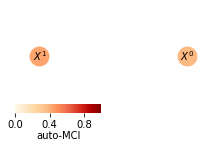

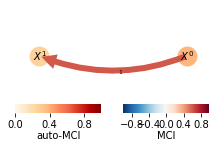

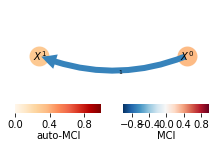

In [6]:
# Causal graph of whole year yields no link because effects average out
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
run_and_plot(ParCorr(mask_type=None), (fig, ax))

# # Causal graph of winter half only gives positive link
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
run_and_plot(ParCorr(mask_type='y'), (fig, ax))

# Causal graph of summer half only gives negative link
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
dataframe.mask = (dataframe.mask == False)
run_and_plot(ParCorr(mask_type='y'),  (fig, ax))


Note, however, that the failure to detect the link on the whole sample occurs only for partial correlatiol because the positive and negative dependencies cancel out. Using CMIknn recovers the link (but gets a false positive for this realization):

(<Figure size 216x144 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd35d0a160>)

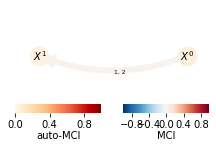

In [7]:
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=CMIknn(mask_type=None, transform='ranks'))
results = pcmci.run_pcmci(tau_max=2,pc_alpha=0.2)
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
tp.plot_graph(fig_ax = (fig, ax),  val_matrix=results['val_matrix'],
              link_matrix=link_matrix, var_names=var_names)